# Analyse Exploratoire

### Importation des modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import cloudpickle
import pickle
from pprint import pprint
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_val_score
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer

from sklearn import linear_model

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Importation des données

In [6]:
building_consumption = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")
building_consumption.shape

(3376, 46)

In [7]:
building_consumption["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [8]:
building_consumption = building_consumption.loc[(building_consumption["BuildingType"] == "NonResidential") |
                                                (building_consumption["BuildingType"] == "Nonresidential COS") |
                                                (building_consumption["BuildingType"] == "Nonresidential WA")]

In [9]:
# Suppression des colonnes qu'on n'a pas besoin ou de string de cardinalité trop élevé
building_consumption.drop(columns=["OSEBuildingID",
                                   "City",
                                   "State",
                                   "Address",
                                   "Comments", 
                                   "PropertyName",
                                   'Longitude',
                                   'Latitude',
                                   "YearsENERGYSTARCertified",
                                   "TaxParcelIdentificationNumber",
                                   "SecondLargestPropertyUseTypeGFA", 
                                   "ListOfAllPropertyUseTypes",
                                   "ThirdLargestPropertyUseTypeGFA"], inplace=True)
building_consumption.shape

(1546, 33)

In [10]:
# Suppression des colonnes qui sont basées sur la colonne de target pour éviter le data leakage
building_consumption.drop(columns=["SiteEnergyUseWN(kBtu)", 
                       'SiteEUI(kBtu/sf)', 
                       'SourceEUI(kBtu/sf)',
                       'SourceEUIWN(kBtu/sf)',
                       'SiteEUIWN(kBtu/sf)',
                       'GHGEmissionsIntensity',
                       'ENERGYSTARScore',
                       'TotalGHGEmissions'], inplace=True)
building_consumption.shape

(1546, 25)

In [11]:
# Calcul de la matrice de corrélation
corr_matrix = building_consumption.corr().abs()

# Création d'une matrice triangulaire supérieure
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identification des colonnes à supprimer
to_drop = ['PropertyGFABuilding(s)', 
           'LargestPropertyUseTypeGFA', 
           'Electricity(kBtu)', 
           'Electricity(kWh)', 
           'NaturalGas(kBtu)']

# Supprimer des colonnes trop corrélés
building_consumption.drop(columns=to_drop, inplace=True)

building_consumption.shape

/var/folders/b8/_p_1v95j6ql648xwdw382p9h0000gn/T/ipykernel_27008/4055215925.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = building_consumption.corr().abs()


(1546, 20)

In [12]:
building_consumption.columns.values

array(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(therms)',
       'DefaultData', 'ComplianceStatus', 'Outlier'], dtype=object)

In [13]:
# Les colonnes supprimées qui ont une corrélation élevée avec les autres colonnes
print(to_drop)  

['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'Electricity(kWh)', 'NaturalGas(kBtu)']


#### Détection des lignes qu'on n'a pas besoin

In [14]:
# Supprimer les lignes dont les codes postales sont vide et dont les lignes sont des outliers
building_consumption = building_consumption.loc[~building_consumption["ZipCode"].isnull(), :]

# Supprimer les lignes des années de contructions qui sont vides
building_consumption =  building_consumption.loc[~building_consumption["YearBuilt"].isnull()]

building_consumption.shape

(1530, 20)

In [15]:
# Suppression des outliers
building_consumption = building_consumption.loc[(building_consumption["PropertyGFATotal"] < 3000000) &
                                          (building_consumption["NumberofBuildings"] < 23) &
                                          (building_consumption["SteamUse(kBtu)"] < 5e+7) &
                                          (building_consumption["NaturalGas(therms)"] < 1.5e+6) &
                                          (building_consumption["Outlier"].isnull())]
building_consumption.drop('Outlier', axis=1, inplace=True)

building_consumption.shape

(1509, 19)

In [16]:
building_consumption.columns.values

array(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(therms)',
       'DefaultData', 'ComplianceStatus'], dtype=object)

###  Feature engineering

In [13]:
# Ajouter comme nouvelle colonne
# district_density = building_consumption.groupby('CouncilDistrictCode')['PropertyGFATotal'].mean()
# building_consumption['DistrictDensity'] = building_consumption['CouncilDistrictCode'].map(district_density)
# building_consumption["BuildingAge"] = building_consumption["DataYear"] - building_consumption["YearBuilt"]
# building_consumption['NumberofFloors'] = building_consumption['NumberofFloors'].replace(0, 1)
# building_consumption["MeanFloorGFA"] = (building_consumption["PropertyGFATotal"] / building_consumption["NumberofFloors"]).round(2)
# building_consumption["RationParking"] = (building_consumption["PropertyGFAParking"] / building_consumption["PropertyGFATotal"]).round(2)

# Changement des colonnes en type string
# building_consumption["ZipCode"] = building_consumption["ZipCode"].astype(int).astype(str)
# building_consumption["CouncilDistrictCode"] = building_consumption["CouncilDistrictCode"].astype(str)
# building_consumption["YearBuilt"] = building_consumption["YearBuilt"].astype(str)
# building_consumption.drop(columns=["DataYear"], inplace=True)

# La colonne ListOfAllPropertyUseTypes est une colonne des tags en format string qui est séparé par une virgule
# Transformer cette colonne est une colonne de liste
# building_consumption["PropertyUseTypes"] = building_consumption["ListOfAllPropertyUseTypes"].str.split(',').apply(lambda x: [tag.strip() for tag in x])

# Utilisation de cette colonne pour créer des colonnes binaire par l'intermédiaire de MultiLabelBinarizer()
# mlb = MultiLabelBinarizer()
# tags_encoded = pd.DataFrame(
#     mlb.fit_transform(building_consumption["PropertyUseTypes"]),
#     columns=mlb.classes_,
#     index=building_consumption.index
# )
# building_consumption.shape

# Changement des colonnes en type string
# building_consumption["ZipCode"] = building_consumption["ZipCode"].astype(int).astype(str)
# building_consumption["CouncilDistrictCode"] = building_consumption["CouncilDistrictCode"].astype(str)
# building_consumption["YearBuilt"] = building_consumption["YearBuilt"].astype(str)

# Supprimer la colonne ListOfAllPropertyUseTypes et concaténer les colonnes crées
# df_processed = building_consumption.drop(["ListOfAllPropertyUseTypes", "PropertyUseTypes"], axis=1)
# building_consumption = pd.concat([df_processed, tags_encoded], axis=1)
# building_consumption.reset_index(drop=True, inplace=True)

# One Hot Encoding sur les années de construction
# enc = OneHotEncoder()
# labels = enc.fit_transform(building_consumption.YearBuilt.values.reshape(-1, 1)).toarray()

# Concatérner le dataset initial avec les données encodées
# encoded_df = pd.DataFrame(columns = enc.get_feature_names_out(['YearBuilt']), data = labels)
# encoded_df = encoded_df.reset_index(drop=True)
# df = pd.concat([building_consumption, encoded_df],axis = 1)
# df.drop("YearBuilt", axis=1, inplace=True)

# One Hot Encoding sur les autres colonnes
# for column in df.select_dtypes(["object"]).columns.values:
#     enc = OneHotEncoder()
#     labels = enc.fit_transform(df[column].values.reshape(-1, 1)).toarray()
#     
#     # Concatérner le dataset initial avec les données encodées
#     encoded_df = pd.DataFrame(columns = enc.get_feature_names_out([column]), data = labels)
#     encoded_df = encoded_df.reset_index(drop=True)
#     df = pd.concat([df, encoded_df],axis = 1)
#     df.drop(column, axis=1, inplace=True)
#     
# Remplacer les nan par 0
# df_final = df.replace(np.nan, 0)

### Création de pipeline avec les étapes de traîtement en haut

In [17]:
class UsageCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['CountUsage'] = X_copy.apply(
            lambda row: sum(1 for col in ['PrimaryPropertyType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
                          if row[col]), axis=1
        )
        return X_copy.drop(columns=['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'])

class DistrictDensityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.district_density = None
    
    def fit(self, X, y=None):
        self.district_density = X.groupby('CouncilDistrictCode')['PropertyGFATotal'].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['DistrictDensity'] = X_copy['CouncilDistrictCode'].map(self.district_density)
        return X_copy

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["BuildingAge"] = X_copy["DataYear"] - X_copy["YearBuilt"]
        X_copy['NumberofFloors'] = X_copy['NumberofFloors'].replace(0, 1)
        X_copy["MeanFloorGFA"] = (X_copy["PropertyGFATotal"] / X_copy["NumberofFloors"]).round(2)
        X_copy["RationParking"] = (X_copy["PropertyGFAParking"] / X_copy["PropertyGFATotal"]).round(2)
        return X_copy

class TypeConversionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["ZipCode"] = X_copy["ZipCode"].astype(int).astype(str)
        X_copy["CouncilDistrictCode"] = X_copy["CouncilDistrictCode"].astype(str)
        X_copy["YearBuilt"] = X_copy["YearBuilt"].astype(str)
        return X_copy.drop(columns=["DataYear"])

class PropertyTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
        
    def fit(self, X, y=None):
        property_types = X["ListOfAllPropertyUseTypes"].str.split(',').apply(lambda x: [tag.strip() for tag in x])
        self.mlb.fit(property_types)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        property_types = X_copy["ListOfAllPropertyUseTypes"].str.split(',').apply(lambda x: [tag.strip() for tag in x])
        tags_encoded = pd.DataFrame(
            self.mlb.transform(property_types),
            columns=self.mlb.classes_,
            index=X_copy.index
        )
        X_copy = X_copy.drop(["ListOfAllPropertyUseTypes"], axis=1)
        return pd.concat([X_copy, tags_encoded], axis=1)

class CategoricalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        self.all_feature_names = {}
        
    def fit(self, X, y=None):
        for column in X.select_dtypes(["object"]).columns:
            encoder = OneHotEncoder(handle_unknown='ignore')  # Ajout de handle_unknown='ignore'
            self.encoders[column] = encoder
            self.encoders[column].fit(X[column].values.reshape(-1, 1))
            # Stocker les noms des features pour chaque colonne
            self.all_feature_names[column] = self.encoders[column].get_feature_names_out([column])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.encoders.keys():
            if column in X_copy.columns:
                # Transformation pour les colonnes présentes
                encoded = self.encoders[column].transform(X_copy[column].values.reshape(-1, 1)).toarray()
                feature_names = self.all_feature_names[column]
            else:
                # Création d'une matrice de zéros pour les colonnes manquantes
                encoded = np.zeros((len(X_copy), len(self.all_feature_names[column])))
                feature_names = self.all_feature_names[column]
            
            encoded_df = pd.DataFrame(encoded, columns=feature_names, index=X_copy.index)
            X_copy = pd.concat([X_copy, encoded_df], axis=1)
            
            # Ne supprimer la colonne que si elle existe
            if column in X_copy.columns:
                X_copy = X_copy.drop(column, axis=1)
        
        return X_copy.fillna(0)
    
class NumericStandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        # Sélectionner uniquement les colonnes numériques
        numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        self.numeric_columns = numeric_columns
        self.scaler.fit(X[numeric_columns])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Standardiser uniquement les colonnes numériques
        if len(self.numeric_columns) > 0:
            X_copy[self.numeric_columns] = self.scaler.transform(X_copy[self.numeric_columns])
        return X_copy

# Création de la pipeline 
preprocessing_pipeline = Pipeline([
    ('usage_count', UsageCountTransformer()),
    ('district_density', DistrictDensityTransformer()),
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('type_conversion', TypeConversionTransformer()),
    #('property_type', PropertyTypeTransformer()),
    ('categorical_encoding', CategoricalEncoderTransformer()),
    ('standard_scaler', NumericStandardScalerTransformer())
])

A réaliser :

- Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
- Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
- Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
- Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
- Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
- Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

### Préparation des features pour la modélisation

In [18]:
building_consumption.rename(columns={"SteamUse(kBtu)": "SteamUsekBtu", "NaturalGas(therms)": "NaturalGasTherms"}, inplace=True)

In [19]:
# Séparation de données en target
y = building_consumption["SiteEnergyUse(kBtu)"]
X = building_consumption.drop(columns=["SiteEnergyUse(kBtu)"])

In [20]:
# Séparation de données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Standarisation des données

# Séparation de données en target
# y_s = df_final["SiteEnergyUse(kBtu)"]
# X_s = df_final.drop(columns=["SiteEnergyUse(kBtu)"])

# Séparation de données en train et test
# X_train_s, X_test_s, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=50)

# scaler_x = StandardScaler()
# X_train_scaled_s = scaler_x.fit_transform(X_train_s)
# X_test_scaled_s = scaler_x.transform(X_test_s)

# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [21]:
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

In [67]:
with open("app/preprocessing.pipeline", 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

In [22]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [68]:
with open('app/y.scaler', 'wb') as f:
    pickle.dump(scaler_y, f)

### Comparaison de différents modèles supervisés

A réaliser :

- Pour chaque algorithme que vous allez tester, vous devez :
    - Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    - Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    - Entrainer le modèle sur le jeu de Train
    - Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    - Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    - Interpréter les résultats pour juger de la fiabilité de l'algorithme.
- Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
- Déterminer le modèle le plus performant parmi ceux testés.

Dummy

In [23]:
# DummyRegressor
dummy = DummyRegressor(strategy='mean') 

# Entraînement avec les données d'entraînement
dummy.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_pred_dummy = dummy.predict(X_test_scaled)

# Calcul des scores
mse_dummy_test = mean_squared_error(y_pred_dummy, y_test_scaled)
mae_dummy_test = mean_absolute_error(y_pred_dummy, y_test_scaled)
rmse_dummy_test = root_mean_squared_error(y_pred_dummy, y_test_scaled)
r2_dummy_test = r2_score(y_pred_dummy, y_test_scaled)

dummy_test_score = {
    "Name": "Dummy",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_dummy_test,
    "MAE": mae_dummy_test,
    "RMSE": rmse_dummy_test,
    "R2": r2_dummy_test
}
pprint(dummy_test_score)

scores = cross_val_score(dummy, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores Cross validation: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 0.4853716666851299,
 'MSE': 0.8474091994161072,
 'Name': 'Dummy',
 'R2': -1.394415699555119e+63,
 'RMSE': 0.9205483145474262}
Scores Cross validation: [-8.40183811e-03 -2.96157223e-05 -8.22006520e-06 -2.39267268e-04
 -9.66286120e-04]
Moyenne: -0.002


In [24]:
# Prediction sur les données de test
y_train_pred_dummy = dummy.predict(X_train_scaled)

# Calcul des scores
mse_dummy_train = mean_squared_error(y_train_pred_dummy, y_train_scaled)
mae_dummy_train = mean_absolute_error(y_train_pred_dummy, y_train_scaled)
rmse_dummy_train = root_mean_squared_error(y_train_pred_dummy, y_train_scaled)
r2_dummy_train = r2_score(y_train_pred_dummy, y_train_scaled)

dummy_train_score = {
    "Name": "Dummy",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_dummy_train,
    "MAE": mae_dummy_train,
    "RMSE": rmse_dummy_train,
    "R2": r2_dummy_train
}
pprint(dummy_train_score)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.47894139765685845,
 'MSE': 1.0,
 'Name': 'Dummy',
 'R2': -4.113761393303015e+62,
 'RMSE': 1.0}


Linear Regression

In [25]:
# LinearRegression
liner_regression = LinearRegression() 

# Entraînement avec les données d'entraînement
liner_regression.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_test_pred_linear_regression = liner_regression.predict(X_test_scaled)

# Calcul des scores
mse_linear_regression_test = mean_squared_error(y_test_pred_linear_regression, y_test_scaled)
mae_linear_regression_test = mean_absolute_error(y_test_pred_linear_regression, y_test_scaled)
rmse_linear_regression_test = root_mean_squared_error(y_test_pred_linear_regression, y_test_scaled)
r2_linear_regression_test = r2_score(y_test_pred_linear_regression, y_test_scaled)

linear_regression_test_pred_score = {
    "Name": "Linear Regression",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_linear_regression_test,
    "MAE": mae_linear_regression_test,
    "RMSE": rmse_linear_regression_test,
    "R2": r2_linear_regression_test
}
pprint(linear_regression_test_pred_score)

scores = cross_val_score(liner_regression, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores Cross validation: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 159809375322.79474,
 'MSE': 1.1327489899403928e+24,
 'Name': 'Linear Regression',
 'R2': -0.023066118905690436,
 'RMSE': 1064306811939.2982}
Scores Cross validation: [-1.52121639e+25 -5.08335172e+26 -4.91814673e+26 -8.21166178e+26
 -4.76149400e+24]
Moyenne: -368257936108480531812843520.000


In [26]:
# Prediction sur les données de test
y_train_pred_linear_regression = liner_regression.predict(X_train_scaled)

# Calcul des scores
mse_linear_regression_train = mean_squared_error(y_train_pred_linear_regression, y_train_scaled)
mae_linear_regression_train = mean_absolute_error(y_train_pred_linear_regression, y_train_scaled)
rmse_linear_regression_train = root_mean_squared_error(y_train_pred_linear_regression, y_train_scaled)
r2_linear_regression_train = r2_score(y_train_pred_linear_regression, y_train_scaled)

linear_regression_train_pred_score = {
    "Name": "Linear Regression",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_linear_regression_train,
    "MAE": mae_linear_regression_train,
    "RMSE": rmse_linear_regression_train,
    "R2": r2_linear_regression_train
}
pprint(linear_regression_train_pred_score)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.16598398687317353,
 'MSE': 0.14257262753362226,
 'Name': 'Linear Regression',
 'R2': 0.833810577205268,
 'RMSE': 0.3775879070277838}


SVR

In [57]:
# SVR
svr = SVR() 

# Entraînement avec les données d'entraînement
svr.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_pred_test_svr = svr.predict(X_test_scaled)

# Calcul des scores
mse_test_svr = mean_squared_error(y_pred_test_svr, y_test_scaled)
mae_test_svr = mean_absolute_error(y_pred_test_svr, y_test_scaled)
rmse_test_svr = root_mean_squared_error(y_pred_test_svr, y_test_scaled)
r2_test_svr = r2_score(y_pred_test_svr, y_test_scaled)

svr_test_score_pred = {
    "Name": "SVR",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_test_svr,
    "MAE": mae_test_svr,
    "RMSE": rmse_test_svr,
    "R2": r2_test_svr
}
pprint(svr_test_score_pred)


scores = cross_val_score(svr, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores Cross validation: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 0.2714887371521605,
 'MSE': 0.5215010062866047,
 'Name': 'SVR',
 'R2': -2.228154403739747,
 'RMSE': 0.7221502657249422}
Scores Cross validation: [0.44678661 0.49408745 0.58419817 0.52021533 0.13016126]
Moyenne: 0.435


In [58]:
# Prediction sur les données de test
y_pred_train_svr = svr.predict(X_train_scaled)

# Calcul des scores
mse_train_svr = mean_squared_error(y_pred_train_svr, y_train_scaled)
mae_train_svr = mean_absolute_error(y_pred_train_svr, y_train_scaled)
rmse_train_svr = root_mean_squared_error(y_pred_train_svr, y_train_scaled)
r2_train_svr = r2_score(y_pred_train_svr, y_train_scaled)

svr_train_score_pred = {
    "Name": "SVR",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_train_svr,
    "MAE": mae_train_svr,
    "RMSE": rmse_train_svr,
    "R2": r2_train_svr
}
pprint(svr_train_score_pred)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.16279687958911837,
 'MSE': 0.49906536666581097,
 'Name': 'SVR',
 'R2': -0.9342558014349913,
 'RMSE': 0.7064455864861857}


Random Forest

In [28]:
# RandomForestRegressor
random_forest = RandomForestRegressor() 

# Entraînement avec les données d'entraînement
random_forest.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_test_pred_random_forest = random_forest.predict(X_test_scaled)

# Calcul des scores
mse_test_random_forest = mean_squared_error(y_test_pred_random_forest, y_test_scaled)
mae_test_random_forest = mean_absolute_error(y_test_pred_random_forest, y_test_scaled)
rmse_test_random_forest = root_mean_squared_error(y_test_pred_random_forest, y_test_scaled)
r2_test_random_forest = r2_score(y_test_pred_random_forest, y_test_scaled)

random_forest_test_score_pred = {
    "Name": "Random Forest",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_test_random_forest,
    "MAE": mae_test_random_forest,
    "RMSE": rmse_test_random_forest,
    "R2": r2_test_random_forest
}
pprint(random_forest_test_score_pred)

scores = cross_val_score(random_forest, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 0.17971505822584094,
 'MSE': 0.23263495483605634,
 'Name': 'Random Forest',
 'R2': 0.5164460061898875,
 'RMSE': 0.48232245939418616}
Scores: [0.69703579 0.64818255 0.60331073 0.36315662 0.36252167]
Moyenne: 0.535


In [30]:
# Prediction sur les données de test
y_train_pred_random_forest = random_forest.predict(X_train_scaled)

# Calcul des scores
mse_train_random_forest = mean_squared_error(y_train_pred_random_forest, y_train_scaled)
mae_train_random_forest = mean_absolute_error(y_train_pred_random_forest, y_train_scaled)
rmse_train_random_forest = root_mean_squared_error(y_train_pred_random_forest, y_train_scaled)
r2_train_random_forest = r2_score(y_train_pred_random_forest, y_train_scaled)

random_forest_train_score_pred = {
    "Name": "Random Forest",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_train_random_forest,
    "MAE": mae_train_random_forest,
    "RMSE": rmse_train_random_forest,
    "R2": r2_train_random_forest
}
pprint(random_forest_train_score_pred)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.07012261610190498,
 'MSE': 0.07324149089132957,
 'Name': 'Random Forest',
 'R2': 0.8905062405280327,
 'RMSE': 0.27063165168052605}


Linear Regression avec régulateur Lasso

In [31]:
# LinearRegrssion avec régularisation Lasso
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train_scaled)

y_pred_test_lasso = lasso.predict(X_test_scaled)

# Calcul des scores
mse_test_lasso = mean_squared_error(y_pred_test_lasso, y_test_scaled)
mae_test_lasso = mean_absolute_error(y_pred_test_lasso, y_test_scaled)
rmse_test_lasso = root_mean_squared_error(y_pred_test_lasso, y_test_scaled)
r2_test_lasso = r2_score(y_pred_test_lasso, y_test_scaled)


# Calcul des scores
lasso_test_score_pred = {
    "Name": "Lasso",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_test_lasso,
    "MAE": mae_test_lasso,
    "RMSE": rmse_test_lasso,
    "R2": r2_test_lasso
}

pprint(lasso_test_score_pred)

scores = cross_val_score(lasso, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 0.17968992553172194,
 'MSE': 0.13892264623382145,
 'Name': 'Lasso',
 'R2': 0.7424072672973316,
 'RMSE': 0.3727232837291245}
Scores: [ 0.65686457  0.64495918  0.75967802 -0.14157105  0.45102803]
Moyenne: 0.474


In [32]:
y_pred_train_lasso = lasso.predict(X_train_scaled)

# Calcul des scores
mse_train_lasso = mean_squared_error(y_pred_train_lasso, y_train_scaled)
mae_train_lasso = mean_absolute_error(y_pred_train_lasso, y_train_scaled)
rmse_train_lasso = root_mean_squared_error(y_pred_train_lasso, y_train_scaled)
r2_train_lasso = r2_score(y_pred_train_lasso, y_train_scaled)


# Calcul des scores
lasso_train_score_pred = {
    "Name": "Lasso",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_train_lasso,
    "MAE": mae_train_lasso,
    "RMSE": rmse_train_lasso,
    "R2": r2_train_lasso
}

pprint(lasso_train_score_pred)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.19376151981006,
 'MSE': 0.2571870899297426,
 'Name': 'Lasso',
 'R2': 0.4951445890892595,
 'RMSE': 0.5071361650777261}


Linear Regression avec régulateur Ridge

In [33]:
# LinearRegrssion avec régularisation Ridge
ridge = linear_model.Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train_scaled)

y_pred_test_ridge = ridge.predict(X_test_scaled)

# Calcul des scores
mse_test_ridge = mean_squared_error(y_pred_test_ridge, y_test_scaled)
mae_test_ridge = mean_absolute_error(y_pred_test_ridge, y_test_scaled)
rmse_test_ridge = root_mean_squared_error(y_pred_test_ridge, y_test_scaled)
r2_test_ridge = r2_score(y_pred_test_ridge, y_test_scaled)


# Calcul des scores
ridge_test_score_pred = {
    "Name": "Ridge",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_test_ridge,
    "MAE": mae_test_ridge,
    "RMSE": rmse_test_ridge,
    "R2": r2_test_ridge
}

pprint(ridge_test_score_pred)

scores = cross_val_score(ridge, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 0.1960518063153131,
 'MSE': 0.13263998007803493,
 'Name': 'Ridge',
 'R2': 0.8465940939502361,
 'RMSE': 0.3641977211324021}
Scores: [ 0.28963206  0.55209125  0.67682667 -1.3860501   0.63951102]
Moyenne: 0.154


In [34]:
y_pred_train_ridge = ridge.predict(X_train_scaled)

# Calcul des scores
mse_train_ridge = mean_squared_error(y_pred_train_ridge, y_train_scaled)
mae_train_ridge = mean_absolute_error(y_pred_train_ridge, y_train_scaled)
rmse_train_ridge = root_mean_squared_error(y_pred_train_ridge, y_train_scaled)
r2_train_ridge = r2_score(y_pred_train_ridge, y_train_scaled)


# Calcul des scores
ridge_train_score_pred = {
    "Name": "Ridge",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_train_ridge,
    "MAE": mae_train_ridge,
    "RMSE": rmse_train_ridge,
    "R2": r2_train_ridge
}

pprint(ridge_train_score_pred)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.16062083549550207,
 'MSE': 0.1413418871747088,
 'Name': 'Ridge',
 'R2': 0.8353647146332555,
 'RMSE': 0.3759546344636661}


Xgboost

In [35]:
# XGBOOST
xgboost = XGBRegressor()

# Entraînement avec les données d'entraînement
xgboost.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_pred_test_xgboost = xgboost.predict(X_test_scaled)

mse_test_xgboost = mean_squared_error(y_pred_test_xgboost, y_test_scaled)
mae_test_xgboost = mean_absolute_error(y_pred_test_xgboost, y_test_scaled)
rmse_test_xgboost = root_mean_squared_error(y_pred_test_xgboost, y_test_scaled)
r2_test_xgboost = r2_score(y_pred_test_xgboost, y_test_scaled)


# Calcul des scores
xgboost_test_score_pred = {
    "Name": "Xgboost",
    "Data": "Test",
    "GridSearch": False,
    "MSE": mse_test_xgboost,
    "MAE": mae_test_xgboost,
    "RMSE": rmse_test_xgboost,
    "R2": r2_test_xgboost
}

pprint(xgboost_test_score_pred)

scores = cross_val_score(xgboost, X_train_scaled, y_train_scaled, cv=5)
print(f"Scores: {scores}")
print(f"Moyenne: {scores.mean():.3f}")

{'Data': 'Test',
 'GridSearch': False,
 'MAE': 0.1701378404000811,
 'MSE': 0.1627427296464651,
 'Name': 'Xgboost',
 'R2': 0.7064148635999541,
 'RMSE': 0.40341384414328807}
Scores: [ 0.6249486   0.58841434 -0.15715656  0.33306033  0.38877103]
Moyenne: 0.356


In [36]:
y_pred_train_xgboost = xgboost.predict(X_train_scaled)

# Calcul des scores
mse_train_xgboost = mean_squared_error(y_pred_train_xgboost, y_train_scaled)
mae_train_xgboost = mean_absolute_error(y_pred_train_xgboost, y_train_scaled)
rmse_train_xgboost = root_mean_squared_error(y_pred_train_xgboost, y_train_scaled)
r2_train_xgboost = r2_score(y_pred_train_xgboost, y_train_scaled)


# Calcul des scores
xgboost_train_score_pred = {
    "Name": "Xgboost",
    "Data": "Train",
    "GridSearch": False,
    "MSE": mse_train_xgboost,
    "MAE": mae_train_xgboost,
    "RMSE": rmse_train_xgboost,
    "R2": r2_train_xgboost
}

pprint(xgboost_train_score_pred)

{'Data': 'Train',
 'GridSearch': False,
 'MAE': 0.03118262461424985,
 'MSE': 0.002047913825014358,
 'Name': 'Xgboost',
 'R2': 0.9979194161768863,
 'RMSE': 0.04525388187784953}


In [37]:
#with open('app/model/xgb.model', 'wb') as f:
#    pickle.dump(xgboost, f)

### Optimisation et interprétation du modèle

A réaliser :

- Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
- Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.


### GridSearchCV

Linear Regression

In [39]:
# LinearRegression
params = {
   'fit_intercept': [True, False],
   'copy_X': [True, False],
   'positive': [True, False],
   'n_jobs': [None, -1]
}

linear_grid = GridSearchCV(LinearRegression(), params, cv=5)
linear_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {linear_grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(linear_grid.cv_results_)

y_pred_test_gd_linear_regression = linear_grid.predict(X_test_scaled)

mse_test_gd_linear_regression = mean_squared_error(y_pred_test_gd_linear_regression, y_test_scaled)
mae_test_gd_linear_regression = mean_absolute_error(y_pred_test_gd_linear_regression, y_test_scaled)
rmse_test_gd_linear_regression = root_mean_squared_error(y_pred_test_gd_linear_regression, y_test_scaled)
r2_test_gd_linear_regression = r2_score(y_pred_test_gd_linear_regression, y_test_scaled)


# Calcul des scores
linear_regression_test_gd_score_pred = {
    "Name": "Linear Regression",
    "Data": "Test",
    "GridSearch": True,
    "MSE": mse_test_gd_linear_regression,
    "MAE": mae_test_gd_linear_regression,
    "RMSE": rmse_test_gd_linear_regression,
    "R2": r2_test_gd_linear_regression
}

pprint(linear_regression_test_gd_score_pred)

Best params: {'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': True}
{'Data': 'Test',
 'GridSearch': True,
 'MAE': 83630569968.07864,
 'MSE': 2.3470886751074655e+23,
 'Name': 'Linear Regression',
 'R2': -0.030714175706805902,
 'RMSE': 484467612447.6708}


In [40]:
y_pred_train_gd_linear_regression = linear_grid.predict(X_train_scaled)

mse_train_gd_linear_regression = mean_squared_error(y_pred_train_gd_linear_regression, y_train_scaled)
mae_train_gd_linear_regression = mean_absolute_error(y_pred_train_gd_linear_regression, y_train_scaled)
rmse_train_gd_linear_regression = root_mean_squared_error(y_pred_train_gd_linear_regression, y_train_scaled)
r2_train_gd_linear_regression = r2_score(y_pred_train_gd_linear_regression, y_train_scaled)


# Calcul des scores
linear_regression_train_gd_score_pred = {
    "Name": "Linear Regression",
    "Data": "Train",
    "GridSearch": True,
    "MSE": mse_train_gd_linear_regression,
    "MAE": mae_train_gd_linear_regression,
    "RMSE": rmse_train_gd_linear_regression,
    "R2": r2_train_gd_linear_regression
}

pprint(linear_regression_train_gd_score_pred)

{'Data': 'Train',
 'GridSearch': True,
 'MAE': 0.16150702851329693,
 'MSE': 0.14417664980206163,
 'Name': 'Linear Regression',
 'R2': 0.8318499249918903,
 'RMSE': 0.3797060044324578}


Feature: NumberofBuildings, Score: 0.00000
Feature: NumberofFloors, Score: 0.01469
Feature: PropertyGFATotal, Score: 0.29382
Feature: PropertyGFAParking, Score: 0.00000
Feature: SteamUsekBtu, Score: 0.05117
Feature: NaturalGasTherms, Score: 0.50278
Feature: DefaultData, Score: 0.00011
Feature: CountUsage, Score: 0.00000
Feature: DistrictDensity, Score: 0.00000
Feature: BuildingAge, Score: 21685237875658589997105152.00000
Feature: MeanFloorGFA, Score: 0.00022
Feature: RationParking, Score: 0.00000
Feature: Adult Education, Score: 0.00000
Feature: Automobile Dealership, Score: 0.00000
Feature: Bank Branch, Score: 0.00000
Feature: Bar/Nightclub, Score: 0.00003
Feature: College/University, Score: 0.00200
Feature: Convenience Store without Gas Station, Score: 0.00000
Feature: Convention Center, Score: 0.00000
Feature: Courthouse, Score: 0.00000
Feature: Data Center, Score: 0.00313
Feature: Distribution Center, Score: 0.00682
Feature: Dry Cleaning, Score: 0.00000
Feature: Enclosed Mall, Scor

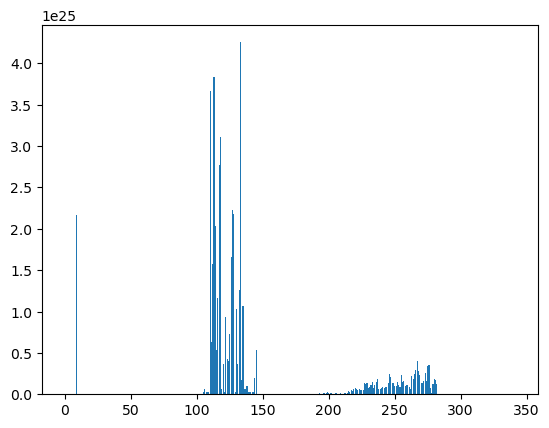

In [42]:
linear_best_model = linear_grid.best_estimator_

results = permutation_importance(linear_best_model, X_train_scaled, y_train_scaled, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_train_scaled.columns.values[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Lasso

In [41]:
# Lasso
params = {
   'alpha': [0.001, 0.01, 0.1, 1, 10],
   'fit_intercept': [True, False],
   'max_iter': [1000, 2000],
   'selection': ['cyclic', 'random']
}

lasso_grid = GridSearchCV(lasso, params, cv=5)
lasso_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {lasso_grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(lasso_grid.cv_results_)

y_pred_test_gd_lasso = lasso_grid.predict(X_test_scaled)

# Calcul des scores
mse_test_gd_lasso = mean_squared_error(y_pred_test_gd_lasso, y_test_scaled)
mae_test_gd_lasso = mean_absolute_error(y_pred_test_gd_lasso, y_test_scaled)
rmse_test_gd_lasso = root_mean_squared_error(y_pred_test_gd_lasso, y_test_scaled)
r2_test_gd_lasso = r2_score(y_pred_test_gd_lasso, y_test_scaled)


# Calcul des scores
lasso_test_gd_score_pred = {
    "Name": "Lasso",
    "Data": "Test",
    "GridSearch": True,
    "MSE": mse_test_gd_lasso,
    "MAE": mae_test_gd_lasso,
    "RMSE": rmse_test_gd_lasso,
    "R2": r2_test_gd_lasso
}

pprint(lasso_test_gd_score_pred)

Best params: {'alpha': 0.1, 'fit_intercept': False, 'max_iter': 2000, 'selection': 'random'}
{'Data': 'Test',
 'GridSearch': True,
 'MAE': 0.17968321295474904,
 'MSE': 0.13892533399608906,
 'Name': 'Lasso',
 'R2': 0.7424074687485469,
 'RMSE': 0.372726889285022}


In [69]:
lasso_best_model = lasso_grid.best_estimator_

with open('app/model/lasso.model', 'wb') as f:
    pickle.dump(lasso_best_model, f)

In [42]:
y_pred_train_gd_lasso = lasso_grid.predict(X_train_scaled)

mse_train_gd_lasso = mean_squared_error(y_pred_train_gd_lasso, y_train_scaled)
mae_train_gd_lasso = mean_absolute_error(y_pred_train_gd_lasso, y_train_scaled)
rmse_train_gd_lasso = root_mean_squared_error(y_pred_train_gd_lasso, y_train_scaled)
r2_train_gd_lasso = r2_score(y_pred_train_gd_lasso, y_train_scaled)


# Calcul des scores
lasso_train_gd_score_pred = {
    "Name": "Lasso",
    "Data": "Train",
    "GridSearch": True,
    "MSE": mse_train_gd_linear_regression,
    "MAE": mae_train_gd_linear_regression,
    "RMSE": rmse_train_gd_linear_regression,
    "R2": r2_train_gd_linear_regression
}

pprint(lasso_train_gd_score_pred)

{'Data': 'Train',
 'GridSearch': True,
 'MAE': 0.16150702851329693,
 'MSE': 0.14417664980206163,
 'Name': 'Lasso',
 'R2': 0.8318499249918903,
 'RMSE': 0.3797060044324578}


Feature: NumberofBuildings, Score: 0.00000
Feature: NumberofFloors, Score: 0.02168
Feature: PropertyGFATotal, Score: 0.33646
Feature: PropertyGFAParking, Score: 0.00000
Feature: SteamUsekBtu, Score: 0.02271
Feature: NaturalGasTherms, Score: 0.44404
Feature: DefaultData, Score: 0.00000
Feature: CountUsage, Score: 0.00000
Feature: DistrictDensity, Score: 0.00000
Feature: BuildingAge, Score: 0.00000
Feature: MeanFloorGFA, Score: 0.00000
Feature: RationParking, Score: 0.00000
Feature: Adult Education, Score: 0.00000
Feature: Automobile Dealership, Score: 0.00000
Feature: Bank Branch, Score: 0.00000
Feature: Bar/Nightclub, Score: 0.00000
Feature: College/University, Score: 0.00000
Feature: Convenience Store without Gas Station, Score: 0.00000
Feature: Convention Center, Score: 0.00000
Feature: Courthouse, Score: 0.00000
Feature: Data Center, Score: 0.00000
Feature: Distribution Center, Score: 0.00000
Feature: Dry Cleaning, Score: 0.00000
Feature: Enclosed Mall, Score: 0.00000
Feature: Fast 

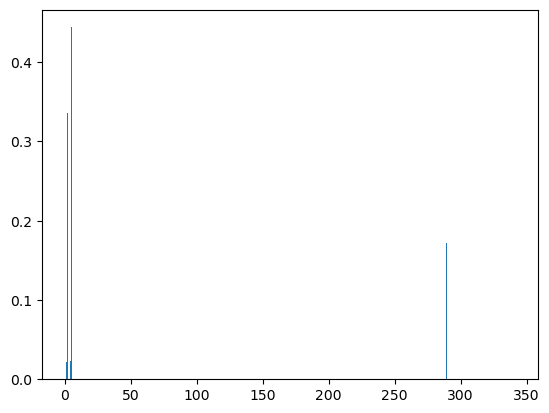

In [45]:
lasso_best_model = lasso_grid.best_estimator_

results = permutation_importance(lasso_best_model, X_train_scaled, y_train_scaled, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_train_scaled.columns.values[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Ridge

In [43]:
# GridSearchCV sur Ridge
params = {
   'alpha': [0.001, 0.01, 0.1, 1, 10],
   'fit_intercept': [True, False],
   'max_iter': [500, 1000]
}

ridge_grid = GridSearchCV(ridge, params, cv=5)
ridge_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {ridge_grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(ridge_grid.cv_results_)

y_pred_test_gd_ridge = ridge_grid.predict(X_test_scaled)

# Calcul des scores
mse_test_gd_ridge = mean_squared_error(y_pred_test_gd_ridge, y_test_scaled)
mae_test_gd_ridge = mean_absolute_error(y_pred_test_gd_ridge, y_test_scaled)
rmse_test_gd_ridge = root_mean_squared_error(y_pred_test_gd_ridge, y_test_scaled)
r2_test_gd_ridge = r2_score(y_pred_test_gd_ridge, y_test_scaled)


# Calcul des scores
ridge_test_gd_score_pred = {
    "Name": "Ridge",
    "Data": "Test",
    "GridSearch": True,
    "MSE": mse_test_gd_ridge,
    "MAE": mae_test_gd_ridge,
    "RMSE": rmse_test_gd_ridge,
    "R2": r2_test_gd_ridge
}

pprint(ridge_test_gd_score_pred)

Best params: {'alpha': 10, 'fit_intercept': False, 'max_iter': 500}
{'Data': 'Test',
 'GridSearch': True,
 'MAE': 0.19314133232005404,
 'MSE': 0.1315571862593571,
 'Name': 'Ridge',
 'R2': 0.845377298001466,
 'RMSE': 0.3627081281958775}


In [60]:
# Score sur la prédiction des données de train avec Ridge
y_pred_train_gd_ridge = ridge_grid.predict(X_train_scaled)

# Calcul des scores
mse_train_gd_ridge = mean_squared_error(y_pred_train_gd_ridge, y_train_scaled)
mae_train_gd_ridge = mean_absolute_error(y_pred_train_gd_ridge, y_train_scaled)
rmse_train_gd_ridge = root_mean_squared_error(y_pred_train_gd_ridge, y_train_scaled)
r2_train_gd_ridge = r2_score(y_pred_train_gd_ridge, y_train_scaled)


# Calcul des scores
ridge_train_gd_score_pred = {
    "Name": "Ridge",
    "Data": "Train",
    "GridSearch": True,
    "MSE": mse_train_gd_ridge,
    "MAE": mae_train_gd_ridge,
    "RMSE": rmse_train_gd_ridge,
    "R2": r2_train_gd_ridge
}

pprint(ridge_train_gd_score_pred)

{'Data': 'Train',
 'GridSearch': True,
 'MAE': 0.15952051025277467,
 'MSE': 0.1415712669095572,
 'Name': 'Ridge',
 'R2': 0.8324891931764916,
 'RMSE': 0.3762595738443837}


In [70]:
ridge_best_model = ridge_grid.best_estimator_

# Sauvegarde de modèle ridge
with open('app/model/ridge.model', 'wb') as f:
    pickle.dump(ridge_best_model, f)

Feature: NumberofBuildings, Score: -0.00007
Feature: NumberofFloors, Score: 0.01587
Feature: PropertyGFATotal, Score: 0.35509
Feature: PropertyGFAParking, Score: 0.00315
Feature: SteamUsekBtu, Score: 0.04848
Feature: NaturalGasTherms, Score: 0.49534
Feature: DefaultData, Score: 0.00000
Feature: CountUsage, Score: 0.00000
Feature: DistrictDensity, Score: 0.00012
Feature: BuildingAge, Score: 0.00023
Feature: MeanFloorGFA, Score: 0.00002
Feature: RationParking, Score: 0.00289
Feature: BuildingType_NonResidential, Score: -0.00005
Feature: BuildingType_Nonresidential COS, Score: -0.00000
Feature: BuildingType_Nonresidential WA, Score: 0.00137
Feature: PrimaryPropertyType_Distribution Center, Score: 0.00070
Feature: PrimaryPropertyType_Hospital, Score: 0.00057
Feature: PrimaryPropertyType_Hotel, Score: 0.00186
Feature: PrimaryPropertyType_K-12 School, Score: 0.00025
Feature: PrimaryPropertyType_Laboratory, Score: 0.00053
Feature: PrimaryPropertyType_Large Office, Score: 0.00526
Feature: Prim

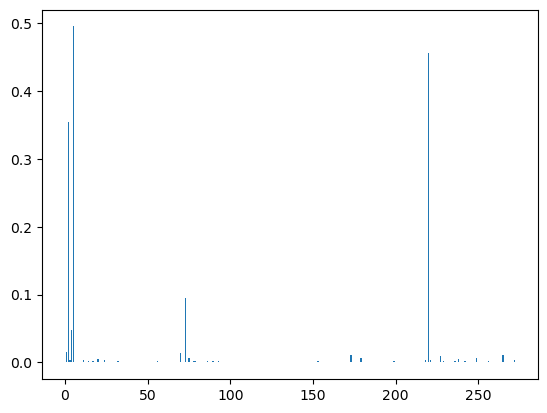

In [71]:
ridge_best_model = ridge_grid.best_estimator_

results = permutation_importance(ridge_best_model, X_train_scaled, y_train_scaled, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_train_scaled.columns.values[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

SVR

In [45]:
# SVR

params = {
    'kernel': ['rbf'],
    'C': [1, 10],  
    'gamma': ['scale', 0.1],
    'epsilon': [0.1]
}

# Initialisation SVR
svr = SVR(cache_size=1000, max_iter=1000)

grid = GridSearchCV(svr, params, cv=5)
grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(grid.cv_results_)

y_pred_test_gd_svr = grid.predict(X_test_scaled)

mse_test_gd_svr = mean_squared_error(y_pred_test_gd_svr, y_test_scaled)
mae_test_gd_svr = mean_absolute_error(y_pred_test_gd_svr, y_test_scaled)
rmse_test_gd_svr = root_mean_squared_error(y_pred_test_gd_svr, y_test_scaled)
r2_test_gd_svr = r2_score(y_pred_test_gd_svr, y_test_scaled)


svr_test_gd_score_pred = {
    "Name": "SVR",
    "Data": "Test",
    "GridSearch": True,
    "MSE": mse_test_gd_svr,
    "MAE": mae_test_gd_svr,
    "RMSE": rmse_test_gd_svr,
    "R2": r2_test_gd_svr
}

pprint(svr_test_gd_score_pred)

svr_best_model = grid.best_estimator_

#with open('app/model/svr.model', 'wb') as f:
#    pickle.dump(svr_best_model, f)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i

Best params: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
{'Data': 'Test',
 'GridSearch': True,
 'MAE': 0.2811940313444932,
 'MSE': 0.32184894273268816,
 'Name': 'SVR',
 'R2': 0.10264822949011887,
 'RMSE': 0.5673173210229775}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [46]:
# Score sur la prédiction des données de train avec SVR
y_pred_train_gd_svr = grid.predict(X_train_scaled)

mse_train_gd_svr = mean_squared_error(y_pred_train_gd_svr, y_train_scaled)
mae_train_gd_svr = mean_absolute_error(y_pred_train_gd_svr, y_train_scaled)
rmse_train_gd_svr = root_mean_squared_error(y_pred_train_gd_svr, y_train_scaled)
r2_train_gd_svr = r2_score(y_pred_train_gd_svr, y_train_scaled)


svr_train_gd_score_pred = {
    "Name": "SVR",
    "Data": "Train",
    "GridSearch": True,
    "MSE": mse_train_gd_svr,
    "MAE": mae_train_gd_svr,
    "RMSE": rmse_train_gd_svr,
    "R2": r2_train_gd_svr
}

pprint(svr_train_gd_score_pred)

{'Data': 'Train',
 'GridSearch': True,
 'MAE': 0.09642091463536986,
 'MSE': 0.08796953349746339,
 'Name': 'SVR',
 'R2': 0.8661180682044765,
 'RMSE': 0.2965965837589223}


In [65]:
best_model = grid.best_estimator_

results = permutation_importance(best_model, X_train_scaled, y_train_scaled, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

Feature: NumberofBuildings, Score: 0.04325
Feature: NumberofFloors, Score: 0.03572
Feature: PropertyGFATotal, Score: 0.10977
Feature: PropertyGFAParking, Score: 0.00611
Feature: SteamUsekBtu, Score: 0.02436
Feature: NaturalGasTherms, Score: 0.18102
Feature: DefaultData, Score: 0.00000
Feature: CountUsage, Score: 0.00000
Feature: DistrictDensity, Score: 0.00271
Feature: BuildingAge, Score: 0.00144
Feature: MeanFloorGFA, Score: 0.01481
Feature: RationParking, Score: 0.00386
Feature: BuildingType_NonResidential, Score: 0.00088
Feature: BuildingType_Nonresidential COS, Score: 0.00088
Feature: BuildingType_Nonresidential WA, Score: 0.00301
Feature: PrimaryPropertyType_Distribution Center, Score: 0.00083
Feature: PrimaryPropertyType_Hospital, Score: 0.11015
Feature: PrimaryPropertyType_Hotel, Score: 0.00117
Feature: PrimaryPropertyType_K-12 School, Score: 0.00090
Feature: PrimaryPropertyType_Laboratory, Score: 0.00414
Feature: PrimaryPropertyType_Large Office, Score: 0.00727
Feature: Primary

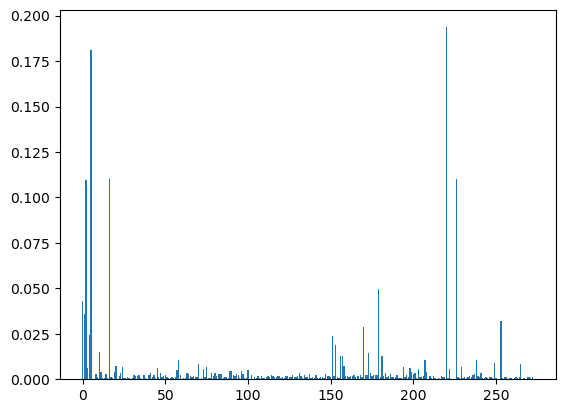

In [66]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_train_scaled.columns.values[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

RandomForestRegressor

In [47]:
# RandomForestRegressor


# Définition de la grille de paramètres à tester
params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 30, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]
}


rf_grid = GridSearchCV(
    estimator=random_forest,
    param_grid=params,
    cv=5,         
    n_jobs=-1,         
    scoring='r2',     
)

rf_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(grid.cv_results_)

y_pred_test_gd_random_forest = rf_grid.predict(X_test_scaled)


mse_test_gd_random_forest = mean_squared_error(y_pred_test_gd_random_forest, y_test_scaled)
mae_test_gd_random_forest = mean_absolute_error(y_pred_test_gd_random_forest, y_test_scaled)
rmse_test_gd_random_forest = root_mean_squared_error(y_pred_test_gd_random_forest, y_test_scaled)
r2_test_gd_random_forest = r2_score(y_pred_test_gd_random_forest, y_test_scaled)


# Calcul des scores
random_forest_test_gd_score_pred = {
    "Name": "Random Forest",
    "Data": "Test",
    "GridSearch": True,
    "MSE": mse_test_gd_random_forest,
    "MAE": mae_test_gd_random_forest,
    "RMSE": rmse_test_gd_random_forest,
    "R2": r2_test_gd_random_forest
}

pprint(random_forest_test_gd_score_pred)


rf_best_model = rf_grid.best_estimator_
# joblib.dump(rf_best_model, 'model/rf.model')

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
{'Data': 'Test',
 'GridSearch': True,
 'MAE': 0.16802349847050627,
 'MSE': 0.15887214221981788,
 'Name': 'Random Forest',
 'R2': 0.7504547723777253,
 'RMSE': 0.39858768448086535}


In [76]:
rf_best_model = rf_grid.best_estimator_

#with open('app/model/rf.model', 'wb') as f:
#    pickle.dump(rf_best_model, f)

In [48]:
# Score sur la prédiction des données de train avec Random Forest
y_pred_train_gd_random_forest = rf_grid.predict(X_train_scaled)


mse_train_gd_random_forest = mean_squared_error(y_pred_train_gd_random_forest, y_train_scaled)
mae_train_gd_random_forest = mean_absolute_error(y_pred_train_gd_random_forest, y_train_scaled)
rmse_train_gd_random_forest = root_mean_squared_error(y_pred_train_gd_random_forest, y_train_scaled)
r2_train_gd_random_forest = r2_score(y_pred_train_gd_random_forest, y_train_scaled)


# Calcul des scores
random_forest_train_gd_score_pred = {
    "Name": "Random Forest",
    "Data": "Train",
    "GridSearch": True,
    "MSE": mse_train_gd_random_forest,
    "MAE": mae_train_gd_random_forest,
    "RMSE": rmse_train_gd_random_forest,
    "R2": r2_train_gd_random_forest
}

pprint(random_forest_train_gd_score_pred)

{'Data': 'Train',
 'GridSearch': True,
 'MAE': 0.12707196240843388,
 'MSE': 0.24717043847476694,
 'Name': 'Random Forest',
 'R2': 0.5311554532122797,
 'RMSE': 0.49716238642396}


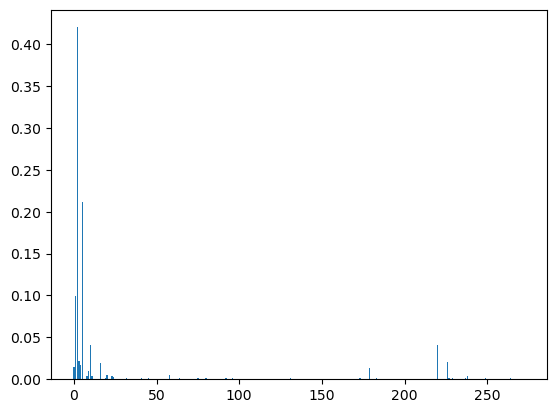

In [64]:
plt.bar(range(len(rf_best_model.feature_importances_)), rf_best_model.feature_importances_)
plt.show()

Xgboost

In [49]:
# XGBOOST avec GridSearchCV

params = {
    'n_estimators': [500],
    'max_depth': [7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.8, 0.9],
    #'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgboost, 
                    params, 
                    cv=5,
                    scoring="r2"
                   )

xgb_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {xgb_grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(xgb_grid.cv_results_)

y_pred_test_gd_xgboost = xgb_grid.predict(X_test_scaled)

mse_test_gd_xgboost = mean_squared_error(y_pred_test_gd_xgboost, y_test_scaled)
mae_test_gd_xgboost = mean_absolute_error(y_pred_test_gd_xgboost, y_test_scaled)
rmse_test_gd_xgboost = root_mean_squared_error(y_pred_test_gd_xgboost, y_test_scaled)
r2_test_gd_xgboost = r2_score(y_pred_test_gd_xgboost, y_test_scaled)


# Calcul des scores
xgb_test_gd_score_pred = {
    "Name": "Xgboost",
    "Data": "Test",
    "GridSearch": True,
    "MSE": mse_test_gd_xgboost,
    "MAE": mae_test_gd_xgboost,
    "RMSE": rmse_test_gd_xgboost,
    "R2": r2_test_gd_xgboost
}

pprint(xgb_test_gd_score_pred)


# Sauvegarde du model
xgb_best_model = xgb_grid.best_estimator_
# joblib.dump(xgb_best_model, 'model/xgb.model')

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500}
{'Data': 'Test',
 'GridSearch': True,
 'MAE': 0.15810870475864885,
 'MSE': 0.11820677119328661,
 'Name': 'Xgboost',
 'R2': 0.81984681547303,
 'RMSE': 0.3438121161234528}


In [63]:
# Sauvagarde de modèle
with open('app/model/xgb.model', 'wb') as f:
    pickle.dump(xgb_best_model, f)

In [51]:
# Score sur la prédiction des données de train avec Xgboost
y_pred_train_gd_xgboost = xgb_grid.predict(X_train_scaled)


mse_train_gd_xgboost = mean_squared_error(y_pred_train_gd_xgboost, y_train_scaled)
mae_train_gd_xgboost = mean_absolute_error(y_pred_train_gd_xgboost, y_train_scaled)
rmse_train_gd_xgboost = root_mean_squared_error(y_pred_train_gd_xgboost, y_train_scaled)
r2_train_gd_xgboost = r2_score(y_pred_train_gd_xgboost, y_train_scaled)


# Calcul des scores
xgboost_train_gd_score_pred = {
    "Name": "Xgboost",
    "Data": "Train",
    "GridSearch": True,
    "MSE": mse_train_gd_xgboost,
    "MAE": mae_train_gd_xgboost,
    "RMSE": rmse_train_gd_xgboost,
    "R2": r2_train_gd_xgboost
}

pprint(xgboost_train_gd_score_pred)

{'Data': 'Train',
 'GridSearch': True,
 'MAE': 0.07533518619740531,
 'MSE': 0.018058916760575305,
 'Name': 'Xgboost',
 'R2': 0.9789222194063047,
 'RMSE': 0.13438346907479098}


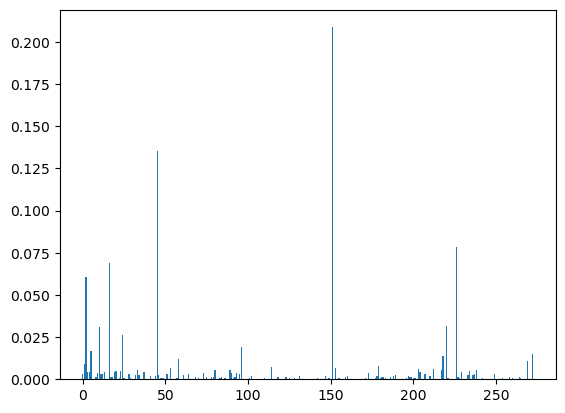

In [52]:
plt.bar(range(len(xgb_best_model.feature_importances_)), xgb_best_model.feature_importances_)
plt.show()

### Les Scores

In [61]:
all_scores = pd.DataFrame(
    [dummy_test_score,
     dummy_train_score,
    linear_regression_test_pred_score,
    linear_regression_train_pred_score,
    svr_test_score_pred,
    svr_train_score_pred,
    random_forest_test_score_pred,
    random_forest_train_score_pred,
    lasso_test_score_pred,
    lasso_train_score_pred,
    ridge_test_score_pred,
    ridge_train_score_pred,
    xgboost_test_score_pred,
    xgboost_train_score_pred,
    linear_regression_test_gd_score_pred,
    linear_regression_train_gd_score_pred,
    lasso_test_gd_score_pred,
    lasso_train_gd_score_pred,
    ridge_test_gd_score_pred,
    ridge_train_gd_score_pred,
    svr_test_gd_score_pred,
    svr_train_gd_score_pred,
    random_forest_test_gd_score_pred,
    random_forest_train_gd_score_pred,
    xgb_test_gd_score_pred,
    xgboost_train_gd_score_pred
    ])

In [62]:
all_scores

,Name,Data,GridSearch,MSE,MAE,RMSE,R2
0,Dummy,Test,False,8.474092e-01,4.853717e-01,9.205483e-01,-1.394416e+63
1,Dummy,Train,False,1.000000e+00,4.789414e-01,1.000000e+00,-4.113761e+62
2,Linear Regression,Test,False,1.132749e+24,1.598094e+11,1.064307e+12,-2.306612e-02
3,Linear Regression,Train,False,1.425726e-01,1.659840e-01,3.775879e-01,8.338106e-01
4,SVR,Test,False,5.215010e-01,2.714887e-01,7.221503e-01,-2.228154e+00
5,SVR,Train,False,4.990654e-01,1.627969e-01,7.064456e-01,-9.342558e-01
6,Random Forest,Test,False,2.326350e-01,1.797151e-01,4.823225e-01,5.164460e-01
7,Random Forest,Train,False,7.324149e-02,7.012262e-02,2.706317e-01,8.905062e-01
8,Lasso,Test,False,1.389226e-01,1.796899e-01,3.727233e-01,7.424073e-01
9,Lasso,Train,False,2.571871e-01,1.937615e-01,5.071362e-01,4.951446e-01


In [63]:
X_train.columns.values

array(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'SteamUsekBtu', 'NaturalGasTherms',
       'DefaultData', 'ComplianceStatus'], dtype=object)

In [64]:
X_train.dtypes

DataYear                          int64
BuildingType                     object
PrimaryPropertyType              object
ZipCode                         float64
CouncilDistrictCode               int64
Neighborhood                     object
YearBuilt                         int64
NumberofBuildings               float64
NumberofFloors                    int64
PropertyGFATotal                  int64
PropertyGFAParking                int64
ListOfAllPropertyUseTypes        object
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ThirdLargestPropertyUseType      object
SteamUsekBtu                    float64
NaturalGasTherms                float64
DefaultData                        bool
ComplianceStatus                 object
dtype: object